# Multi-Task Progressive Pretrain + Finetune

使用 `FlexibleMultiTaskModel` + `CompoundDataModule` 进行多任务渐进式预训练，并微调到分类任务。

**Source Tasks (Pretrain)**:
- 2 Regression: `Density (normalized)`, `Efermi (normalized)`
- 2 Kernel Regression: `DOS density (normalized)`, `Thermal conductivity (normalized)`

**Target Task (Finetune)**:
- 1 Classification: `Material type`

**训练策略** (参考 `dynamic_task_suite.py`):
- 每个 run 随机排列 source task 顺序
- 逐阶段追加 source task 预训练 (stage 1: 1 task, stage 2: 2 tasks, ...)
- 每个 pretrain stage 完成后，冻结 encoder，finetune 到 classification
- 观察分类性能随 pretrain 阶段数的变化

In [1]:
import copy
import json
import random
from datetime import datetime
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from IPython.core.interactiveshell import InteractiveShell
from KRFD_utils import init_centers_and_sigmas
from lightning import Trainer, seed_everything
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from loguru import logger as fm_logger
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    r2_score,
)

from foundation_model.data.datamodule import CompoundDataModule
from foundation_model.models.flexible_multi_task_model import FlexibleMultiTaskModel
from foundation_model.models.model_config import (
    ClassificationTaskConfig,
    EncoderType,
    KernelRegressionTaskConfig,
    MLPEncoderConfig,
    OptimizerConfig,
    RegressionTaskConfig,
    TaskType,
    TransformerEncoderConfig,
)

InteractiveShell.instance().ast_node_interactivity = "all"
torch.set_float32_matmul_precision("medium")
fm_logger.disable("foundation_model")

# Allow safe unpickling of task config objects stored in checkpoints
torch.serialization.add_safe_globals([
    RegressionTaskConfig,
    ClassificationTaskConfig,
    KernelRegressionTaskConfig,
    OptimizerConfig,
    MLPEncoderConfig,
    TransformerEncoderConfig,
    TaskType,
    EncoderType,
])

## 1. 数据加载与探索

In [2]:
preprocessing_objects = joblib.load("../data/preprocessing_objects_20250615.pkl.z")

all_data = pd.read_parquet(
    "../data/qc_ac_te_mp_dos_reformat_20250615_enforce_quaternary_test.pd.parquet"
)
# 移除预处理中标记的异常样本
dropped_idx = preprocessing_objects.get("dropped_idx", [])
all_data = all_data.loc[~all_data.index.isin(dropped_idx)]

desc_trans = pd.read_parquet(
    "../data/qc_ac_te_mp_dos_composition_desc_trans_20250615.pd.parquet"
)

print(f"Total samples: {len(all_data)}")
print(f"Descriptor shape: {desc_trans.shape}")
print(f"\nSplit distribution:")
print(all_data["split"].value_counts())

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PowerTransformer from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to un

Total samples: 48998
Descriptor shape: (48998, 290)

Split distribution:
split
train    34295
test      7354
val       7349
Name: count, dtype: int64


In [3]:
# --- 检查每个任务的数据可用性 ---
task_columns_info = {
    "Density (normalized)": ("regression", None),
    "Efermi (normalized)": ("regression", None),
    "Material type (label)": ("classification", None),
    "DOS density (normalized)": ("kernel_regression", "DOS energy"),
    "Thermal conductivity (normalized)": ("kernel_regression", "Thermal conductivity (T/K)"),
}

print("=== Task Data Availability ===")
for col, (task_type, t_col) in task_columns_info.items():
    if col in all_data.columns:
        n_valid = all_data[col].notna().sum()
        suffix = f" (t_col: {t_col})" if t_col else ""
        print(f"  {col} [{task_type}]: {n_valid}/{len(all_data)} valid{suffix}")
    else:
        print(f"  {col}: *** COLUMN NOT FOUND ***")

# --- 确定分类类别数 ---
le = preprocessing_objects.get("material_type_label_encoder")
if le is not None:
    num_classes = len(le.classes_)
    class_names = list(le.classes_)
    print(f"\nClassification: {num_classes} classes = {class_names}")
else:
    labels = all_data["Material type (label)"].dropna().astype(int)
    num_classes = int(labels.max()) + 1
    class_names = [str(i) for i in range(num_classes)]
    print(f"\nClassification: {num_classes} classes (no label encoder, using indices)")

# --- 分类标签在各 split 中的分布 ---
clf_mask = all_data["Material type (label)"].notna()
print("\nClassification samples per split:")
print(all_data.loc[clf_mask, "split"].value_counts())

=== Task Data Availability ===
  Density (normalized) [regression]: 33829/48998 valid
  Efermi (normalized) [regression]: 33815/48998 valid
  Material type (label) [classification]: 48998/48998 valid
  DOS density (normalized) [kernel_regression]: 10321/48998 valid (t_col: DOS energy)
  Thermal conductivity (normalized) [kernel_regression]: 6146/48998 valid (t_col: Thermal conductivity (T/K))

Classification: 5 classes = ['DAC', 'DQC', 'IAC', 'IQC', 'others']

Classification samples per split:
split
train    34295
test      7354
val       7349
Name: count, dtype: int64


## 2. 超参数与任务配置

In [4]:
seed_everything(2025)

# === Hyperparameters (参考 dynamic_task_suite_config_radonpy.toml) ===
N_RUNS = 1                      # 随机 task-order 重复次数 (完整实验建议 >=10)
PRETRAIN_MAX_EPOCHS = 10
FINETUNE_MAX_EPOCHS = 10
BATCH_SIZE = 128                # 混合 regression + kernel regression
DEVICE_NUM = 0
RANDOM_SEED_BASE = 1729
DATAMODULE_RANDOM_SEED = 42
EARLY_STOPPING_PATIENCE = 50
LOG_EVERY_N_STEPS = 50

# Encoder
x_dim = desc_trans.shape[1]
LATENT_DIM = 128                # shared_block_dims[-1]

# Head config
HEAD_HIDDEN_DIM = 64
HEAD_LR = 0.005

# Kernel regression specific
N_KERNEL = 15
KR_LR = 5e-4
KR_DECAY = 5e-5

# === Encoder config ===
encoder_config = MLPEncoderConfig(
    hidden_dims=[x_dim, 256, LATENT_DIM],
    norm=True,
    residual=False,
)

print(f"Encoder: input_dim={x_dim}, hidden=[256], latent_dim={LATENT_DIM}")
print(f"N_RUNS={N_RUNS}, pretrain_epochs={PRETRAIN_MAX_EPOCHS}, finetune_epochs={FINETUNE_MAX_EPOCHS}")
print(f"BATCH_SIZE={BATCH_SIZE}, HEAD_LR={HEAD_LR}, KR_LR={KR_LR}")

Seed set to 2025


2025

Encoder: input_dim=290, hidden=[256], latent_dim=128
N_RUNS=1, pretrain_epochs=10, finetune_epochs=10
BATCH_SIZE=128, HEAD_LR=0.005, KR_LR=0.0005


In [5]:
# === 初始化 Kernel Regression 的 centers / sigmas ===

# DOS density: t = DOS energy
dos_t_data = all_data["DOS energy"].dropna()
dos_t_all = np.concatenate(dos_t_data.values)
dos_centers, dos_sigmas = init_centers_and_sigmas(
    t_train=dos_t_all, n_kernels=N_KERNEL, method="quantile",
    sigma_alpha=0.5, t_range=(dos_t_all.min(), dos_t_all.max()),
    inverse_density=True, density_smoothing=0.8,
)

# Thermal conductivity: t = T/K
tc_t_data = all_data["Thermal conductivity (T/K)"].dropna()
tc_t_all = np.concatenate(tc_t_data.values)
tc_centers, tc_sigmas = init_centers_and_sigmas(
    t_train=tc_t_all, n_kernels=N_KERNEL, method="quantile",
    sigma_alpha=0.5, t_range=(tc_t_all.min(), tc_t_all.max()),
    inverse_density=True, density_smoothing=0.8,
)

print(f"DOS density:            {len(dos_t_data)} samples, t ∈ [{dos_t_all.min():.3f}, {dos_t_all.max():.3f}]")
print(f"Thermal conductivity:   {len(tc_t_data)} samples, t ∈ [{tc_t_all.min():.1f}, {tc_t_all.max():.1f}]")

# === 构建所有 Task Configs ===

# --- Source Tasks (pretrain) ---
source_task_configs = {
    "density": RegressionTaskConfig(
        name="density",
        data_column="Density (normalized)",
        dims=[LATENT_DIM, HEAD_HIDDEN_DIM, 1],
        norm=True, residual=False,
        optimizer=OptimizerConfig(lr=HEAD_LR, weight_decay=1e-5),
    ),
    "efermi": RegressionTaskConfig(
        name="efermi",
        data_column="Efermi (normalized)",
        dims=[LATENT_DIM, HEAD_HIDDEN_DIM, 1],
        norm=True, residual=False,
        optimizer=OptimizerConfig(lr=HEAD_LR, weight_decay=1e-5),
    ),
    "dos_density": KernelRegressionTaskConfig(
        name="dos_density",
        data_column="DOS density (normalized)",
        t_column="DOS energy",
        x_dim=[LATENT_DIM, 128, 64],
        t_dim=[16, 8],
        norm=True, residual=False,
        kernel_num_centers=N_KERNEL,
        kernel_learnable_centers=True,
        kernel_learnable_sigmas=True,
        kernel_centers_init=dos_centers.tolist(),
        kernel_sigmas_init=dos_sigmas.tolist(),
        enable_mu3=False,
        optimizer=OptimizerConfig(lr=KR_LR, weight_decay=KR_DECAY),
    ),
    "thermal_conductivity": KernelRegressionTaskConfig(
        name="thermal_conductivity",
        data_column="Thermal conductivity (normalized)",
        t_column="Thermal conductivity (T/K)",
        x_dim=[LATENT_DIM, 128, 64],
        t_dim=[16, 8],
        norm=True, residual=False,
        kernel_num_centers=N_KERNEL,
        kernel_learnable_centers=True,
        kernel_learnable_sigmas=True,
        kernel_centers_init=tc_centers.tolist(),
        kernel_sigmas_init=tc_sigmas.tolist(),
        enable_mu3=False,
        optimizer=OptimizerConfig(lr=KR_LR, weight_decay=KR_DECAY),
    ),
}

# --- Finetune Task (classification) ---
finetune_task_config = ClassificationTaskConfig(
    name="material_type",
    data_column="Material type (label)",
    dims=[LATENT_DIM, HEAD_HIDDEN_DIM, 32],
    num_classes=num_classes,
    norm=True, residual=False,
    optimizer=OptimizerConfig(lr=HEAD_LR, weight_decay=1e-5),
)

SOURCE_TASK_NAMES = list(source_task_configs.keys())
print(f"\nSource tasks: {SOURCE_TASK_NAMES}")
print(f"Finetune task: {finetune_task_config.name} (num_classes={num_classes})")
for name, cfg in source_task_configs.items():
    print(f"  {name}: {type(cfg).__name__}, data_column='{cfg.data_column}'")

DOS density:            10321 samples, t ∈ [-6.000, 10.000]
Thermal conductivity:   6146 samples, t ∈ [0.0, 2090.0]

Source tasks: ['density', 'efermi', 'dos_density', 'thermal_conductivity']
Finetune task: material_type (num_classes=5)
  density: RegressionTaskConfig, data_column='Density (normalized)'
  efermi: RegressionTaskConfig, data_column='Efermi (normalized)'
  dos_density: KernelRegressionTaskConfig, data_column='DOS density (normalized)'
  thermal_conductivity: KernelRegressionTaskConfig, data_column='Thermal conductivity (normalized)'


## 3. Helper Functions

In [6]:
def get_task_columns(task_cfgs):
    """获取 task configs 所需的全部数据列名。"""
    columns = set()
    for cfg in task_cfgs:
        columns.add(cfg.data_column)
        if isinstance(cfg, KernelRegressionTaskConfig):
            columns.add(cfg.t_column)
    return columns


def build_pretrain_datamodule(task_cfgs):
    """构建 pretrain 阶段的 DataModule (包含所有样本，NaN 由 mask 处理)。"""
    columns = list(get_task_columns(task_cfgs))
    if "split" in all_data.columns:
        columns.append("split")
    columns = list(dict.fromkeys(columns))  # deduplicate
    attributes = all_data[columns].copy()

    return CompoundDataModule(
        formula_desc_source=desc_trans,
        attributes_source=attributes,
        task_configs=list(task_cfgs),
        random_seed=DATAMODULE_RANDOM_SEED,
        batch_size=BATCH_SIZE,
        num_workers=0,
    )


def build_finetune_datamodule():
    """构建 finetune 阶段的 DataModule (仅含有效分类标签的样本)。"""
    data_col = finetune_task_config.data_column
    columns = [data_col]
    if "split" in all_data.columns:
        columns.append("split")
    # 仅保留有有效标签的样本
    attributes = all_data[columns].dropna(subset=[data_col]).copy()

    return CompoundDataModule(
        formula_desc_source=desc_trans,
        attributes_source=attributes,
        task_configs=[finetune_task_config],
        random_seed=DATAMODULE_RANDOM_SEED,
        batch_size=BATCH_SIZE,
        num_workers=0,
    )


def collect_clf_predictions(batch_preds):
    """从 trainer.predict 输出中收集分类预测。"""
    labels, probas = [], []
    for batch in batch_preds:
        if "material_type_label" in batch:
            labels.append(batch["material_type_label"])
        if "material_type_proba" in batch:
            probas.append(batch["material_type_proba"])
    pred_labels = np.concatenate(labels) if labels else np.array([])
    pred_probas = np.concatenate(probas) if probas else None
    return pred_labels, pred_probas


def collect_clf_true(dataset):
    """从 dataset 中收集分类真值标签。"""
    y_list = []
    for i in range(len(dataset)):
        sample = dataset[i]
        y = sample[1]["material_type"]  # (1,) long tensor
        y_list.append(y.numpy())
    return np.concatenate(y_list)


def safe_slug(name):
    """将 task name 转换为文件名安全的 slug。"""
    return name.replace(" ", "_").replace("/", "_").replace("(", "").replace(")", "")


print("Helper functions defined.")

Helper functions defined.


## 4. 模型结构验证

In [7]:
# --- 测试: 所有 source tasks 的前向传播 ---
all_source_cfgs = [source_task_configs[n] for n in SOURCE_TASK_NAMES]
model_test = FlexibleMultiTaskModel(
    task_configs=all_source_cfgs,
    encoder_config=copy.deepcopy(encoder_config),
    enable_learnable_loss_balancer=True,
    shared_block_optimizer=OptimizerConfig(lr=5e-2),
)

print("=== Model with all source tasks ===")
for name, head in model_test.task_heads.items():
    print(f"  {name}: {type(head).__name__}")

# Forward pass
x_test = torch.randn(4, x_dim)
t_seqs = {}
for name, cfg in source_task_configs.items():
    if isinstance(cfg, KernelRegressionTaskConfig):
        t_seqs[name] = [torch.randn(10) for _ in range(4)]

with torch.no_grad():
    out = model_test(x_test, t_seqs)

print("\nForward pass output:")
for name, tensor in out.items():
    print(f"  {name}: {tensor.shape}")

# --- 测试: 添加 classification head ---
model_test.add_task(copy.deepcopy(finetune_task_config))
print(f"\nAfter adding classification head: {list(model_test.task_heads.keys())}")

# classification forward
with torch.no_grad():
    out2 = model_test(x_test, t_seqs)
print(f"Classification output shape: {out2['material_type'].shape}")

# --- 测试: remove + add 流程 ---
model_test.remove_tasks(*list(model_test.task_heads.keys()))
model_test.add_task(copy.deepcopy(finetune_task_config))
print(f"\nAfter remove-all + add classification: {list(model_test.task_heads.keys())}")

del model_test
print("\nModel verification passed.")

=== Model with all source tasks ===
  density: RegressionHead
  efermi: RegressionHead
  dos_density: KernelRegressionHead
  thermal_conductivity: KernelRegressionHead

Forward pass output:
  density: torch.Size([4, 1])
  efermi: torch.Size([4, 1])
  dos_density: torch.Size([40, 1])
  thermal_conductivity: torch.Size([40, 1])


FlexibleMultiTaskModel(
  (task_log_sigmas): ParameterDict(
      (density): Parameter containing: [torch.FloatTensor of size ]
      (efermi): Parameter containing: [torch.FloatTensor of size ]
      (dos_density): Parameter containing: [torch.FloatTensor of size ]
      (thermal_conductivity): Parameter containing: [torch.FloatTensor of size ]
      (material_type): Parameter containing: [torch.FloatTensor of size ]
  )
  (encoder): FoundationEncoder(
    (shared): LinearBlock(
      (layers): Sequential(
        (0): LinearLayer(
          (layer): Linear(in_features=290, out_features=256, bias=True)
          (normal): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
        (1): LinearLayer(
          (layer): Linear(in_features=256, out_features=128, bias=True)
          (normal): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): L


After adding classification head: ['density', 'efermi', 'dos_density', 'thermal_conductivity', 'material_type']
Classification output shape: torch.Size([4, 5])


FlexibleMultiTaskModel(
  (task_log_sigmas): ParameterDict()
  (encoder): FoundationEncoder(
    (shared): LinearBlock(
      (layers): Sequential(
        (0): LinearLayer(
          (layer): Linear(in_features=290, out_features=256, bias=True)
          (normal): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
        (1): LinearLayer(
          (layer): Linear(in_features=256, out_features=128, bias=True)
          (normal): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
      )
    )
  )
  (task_heads): ModuleDict()
  (disabled_task_heads): ModuleDict()
  (val_r2_metrics): ModuleDict(
    (density): R2Score()
    (efermi): R2Score()
  )
  (test_r2_metrics): ModuleDict(
    (density): R2Score()
    (efermi): R2Score()
  )
)

FlexibleMultiTaskModel(
  (task_log_sigmas): ParameterDict(  (material_type): Parameter containing: [torch.FloatTensor of size ])
  (encoder): FoundationEncoder(
    (shared): LinearBlock(
      (layers): Sequential(
        (0): LinearLayer(
          (layer): Linear(in_features=290, out_features=256, bias=True)
          (normal): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
        (1): LinearLayer(
          (layer): Linear(in_features=256, out_features=128, bias=True)
          (normal): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
      )
    )
  )
  (task_heads): ModuleDict(
    (material_type): ClassificationHead(
      (hidden_layers): LinearBlock(
        (layers): Sequential(
          (0): LinearLayer(
            (layer): Linear(in_features=128, out_features=64, bias=True)
   


After remove-all + add classification: ['material_type']

Model verification passed.


## 5. Progressive Pretrain + Finetune

每个 run 中：
1. 随机排列 4 个 source task 的顺序
2. Stage 1: 预训练 task[0] → finetune to classification
3. Stage 2: 加载 Stage 1 checkpoint，追加 task[1] 预训练 → finetune
4. Stage 3, 4: 同理
5. 记录每个 stage 后的分类准确率

In [8]:
print("\n=== Progressive Pretrain + Finetune ===")
_ = seed_everything(RANDOM_SEED_BASE)

output_dir = Path(
    f"logs/multi_task_suite/{datetime.now().strftime('%m%d_%H%M')}"
)
output_dir.mkdir(parents=True, exist_ok=True)

experiment_records = []
# 用于汇总: accuracy_matrix[run_idx][stage_idx] = test_accuracy
accuracy_matrix = []

for run_idx in range(1, N_RUNS + 1):
    run_label = f"run{run_idx:02d}"
    run_root = output_dir / run_label
    run_root.mkdir(parents=True, exist_ok=True)

    # 随机排列 source task 顺序
    rng = random.Random(RANDOM_SEED_BASE + run_idx)
    task_sequence = rng.sample(SOURCE_TASK_NAMES, k=len(SOURCE_TASK_NAMES))

    print(f"\n{'='*70}")
    print(f"Run {run_idx}/{N_RUNS}: task order = {task_sequence}")
    print(f"{'='*70}")

    previous_checkpoint = None
    run_records = {
        "run": run_label,
        "task_sequence": task_sequence,
        "pretrain": [],
        "finetune": [],
    }
    run_accuracies = []

    for stage_idx, new_task_name in enumerate(task_sequence, start=1):
        stage_tasks = task_sequence[:stage_idx]
        stage_task_cfgs = [copy.deepcopy(source_task_configs[n]) for n in stage_tasks]

        print(f"\n--- Pretrain Stage {stage_idx}/{len(task_sequence)}: {stage_tasks} ---")

        # ====== 1. Pretrain ======
        dm = build_pretrain_datamodule(stage_task_cfgs)

        if previous_checkpoint is None:
            model = FlexibleMultiTaskModel(
                task_configs=stage_task_cfgs,
                encoder_config=copy.deepcopy(encoder_config),
                enable_learnable_loss_balancer=True,
                shared_block_optimizer=OptimizerConfig(lr=5e-2),
            )
        else:
            model = FlexibleMultiTaskModel.load_from_checkpoint(
                checkpoint_path=previous_checkpoint,
                strict=False,
                enable_learnable_loss_balancer=True,
                encoder_config=copy.deepcopy(encoder_config),
            )
            existing = set(model.task_heads.keys())
            new_cfgs = [cfg for cfg in stage_task_cfgs if cfg.name not in existing]
            if new_cfgs:
                model.add_task(*new_cfgs)

        stage_dir = run_root / f"pretrain_stage{stage_idx:02d}_{safe_slug(new_task_name)}"
        stage_dir.mkdir(parents=True, exist_ok=True)

        ckpt_cb = ModelCheckpoint(
            dirpath=stage_dir / "checkpoints",
            filename=f"{safe_slug(new_task_name)}-{{epoch:02d}}-{{val_final_loss:.4f}}",
            monitor="val_final_loss", mode="min", save_top_k=1,
        )
        early_stop = EarlyStopping(
            monitor="val_final_loss", mode="min", patience=EARLY_STOPPING_PATIENCE,
        )
        loggers = [
            CSVLogger(stage_dir / "logs", name="csv"),
            TensorBoardLogger(stage_dir / "logs", name="tensorboard"),
        ]

        trainer = Trainer(
            max_epochs=PRETRAIN_MAX_EPOCHS,
            accelerator="auto",
            devices=[DEVICE_NUM],
            callbacks=[ckpt_cb, early_stop],
            logger=loggers,
            log_every_n_steps=LOG_EVERY_N_STEPS,
        )
        trainer.fit(model, datamodule=dm)

        best_path = ckpt_cb.best_model_path
        if best_path:
            state = torch.load(best_path, map_location="cpu", weights_only=True)
            model.load_state_dict(state.get("state_dict", state))
            previous_checkpoint = best_path
        print(f"  Pretrain done. Best checkpoint: {best_path or '<none>'}")

        run_records["pretrain"].append({
            "stage": stage_idx,
            "new_task": new_task_name,
            "accumulated_tasks": list(stage_tasks),
            "checkpoint": best_path or None,
        })

        # ====== 2. Finetune to Classification ======
        if previous_checkpoint is None:
            print("  Skipping finetune: no checkpoint available.")
            run_accuracies.append(None)
            continue

        print(f"  Finetuning to classification...")
        ft_model = FlexibleMultiTaskModel.load_from_checkpoint(
            checkpoint_path=previous_checkpoint,
            strict=False,
            enable_learnable_loss_balancer=True,
            freeze_shared_encoder=True,
            encoder_config=copy.deepcopy(encoder_config),
            shared_block_optimizer=OptimizerConfig(lr=5e-2),
        )
        # 移除所有 pretrain heads，添加 classification head
        active_heads = list(ft_model.task_heads.keys())
        if active_heads:
            ft_model.remove_tasks(*active_heads)
        ft_model.add_task(copy.deepcopy(finetune_task_config))

        ft_dm = build_finetune_datamodule()
        ft_dir = stage_dir / "finetune" / "material_type"
        ft_dir.mkdir(parents=True, exist_ok=True)

        ft_ckpt = ModelCheckpoint(
            dirpath=ft_dir / "checkpoints",
            filename="material_type-{epoch:02d}-{val_final_loss:.4f}",
            monitor="val_final_loss", mode="min", save_top_k=1,
        )
        ft_early = EarlyStopping(
            monitor="val_final_loss", mode="min", patience=EARLY_STOPPING_PATIENCE,
        )
        ft_loggers = [
            CSVLogger(ft_dir / "logs", name="csv"),
            TensorBoardLogger(ft_dir / "logs", name="tensorboard"),
        ]

        ft_trainer = Trainer(
            max_epochs=FINETUNE_MAX_EPOCHS,
            accelerator="auto",
            devices=[DEVICE_NUM],
            callbacks=[ft_ckpt, ft_early],
            logger=ft_loggers,
            log_every_n_steps=LOG_EVERY_N_STEPS,
        )
        ft_trainer.fit(ft_model, datamodule=ft_dm)

        # 加载 best checkpoint
        ft_best = ft_ckpt.best_model_path
        if ft_best:
            state = torch.load(ft_best, map_location="cpu", weights_only=True)
            ft_model.load_state_dict(state.get("state_dict", state))

        # ====== 3. Evaluate Classification ======
        ft_dm.setup(stage="fit")
        ft_dm.setup(stage="test")

        test_preds = ft_trainer.predict(ft_model, dataloaders=ft_dm.test_dataloader())
        train_preds = ft_trainer.predict(ft_model, dataloaders=ft_dm.train_dataloader())

        test_labels, test_probas = collect_clf_predictions(test_preds)
        test_true = collect_clf_true(ft_dm.test_dataset)
        train_labels, _ = collect_clf_predictions(train_preds)
        train_true = collect_clf_true(ft_dm.train_dataset)

        # 过滤掉 NaN 标记 (-100)
        test_mask = test_true.flatten() != -100
        train_mask = train_true.flatten() != -100

        test_acc = accuracy_score(test_true.flatten()[test_mask], test_labels.flatten()[test_mask])
        train_acc = accuracy_score(train_true.flatten()[train_mask], train_labels.flatten()[train_mask])

        print(f"  Stage {stage_idx} classification: test_acc={test_acc:.4f}, train_acc={train_acc:.4f}")
        print(classification_report(
            test_true.flatten()[test_mask], test_labels.flatten()[test_mask],
            target_names=class_names, digits=4,
        ))

        run_accuracies.append(float(test_acc))

        # 保存混淆矩阵
        cm = confusion_matrix(
            test_true.flatten()[test_mask], test_labels.flatten()[test_mask],
        )
        fig, ax = plt.subplots(figsize=(8, 6), dpi=120)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names, ax=ax)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_title(f"Run {run_idx} Stage {stage_idx} (tasks: {stage_tasks})")
        fig.savefig(ft_dir / "confusion_matrix.png", bbox_inches="tight")
        plt.close(fig)

        # 保存 metrics
        ft_results = {
            "stage": stage_idx,
            "pretrain_tasks": list(stage_tasks),
            "test_accuracy": float(test_acc),
            "train_accuracy": float(train_acc),
            "checkpoint": ft_best or None,
        }
        run_records["finetune"].append(ft_results)
        with open(ft_dir / "metrics.json", "w") as f:
            json.dump(ft_results, f, indent=2)

    accuracy_matrix.append(run_accuracies)
    experiment_records.append(run_records)

# 保存实验总结
summary_path = output_dir / "experiment_records.json"
with open(summary_path, "w") as f:
    json.dump(experiment_records, f, indent=2)
print(f"\nExperiment records saved to {summary_path}")

Seed set to 1729
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores



=== Progressive Pretrain + Finetune ===

Run 1/1: task order = ['efermi', 'thermal_conductivity', 'density', 'dos_density']

--- Pretrain Stage 1/4: ['efermi'] ---


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name                | Type              | Params | Mode 
------------------------------------------------------------------
0 | task_log_sigmas     | ParameterDict     | 1      | train
1 | encoder             | FoundationEncoder | 108 K  | train
2 | task_heads          | ModuleDict        | 8.4 K  | train
3 | disabled_task_heads | ModuleDict        | 0      | train
4 | val_r2_metrics      | ModuleDict        | 0      | train
5 | test_r2_metrics     | ModuleDict        | 0      | train
------------------------------------------------------------------
116 K     Trainable params
0         Non-trainable params
116 K     Total params
0.466     Total estimated model params size (MB)
28        Modules in train mode
0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 268/268 [00:01<00:00, 157.26it/s, v_num=0, train_final_loss_step=-0.196, val_final_loss=-0.316, train_final_loss_epoch=-0.309] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 268/268 [00:01<00:00, 156.09it/s, v_num=0, train_final_loss_step=-0.196, val_final_loss=-0.316, train_final_loss_epoch=-0.309]


<All keys matched successfully>

  Pretrain done. Best checkpoint: /Users/liuchang/projects/foundation_model/notebooks/logs/multi_task_suite/0211_0247/run01/pretrain_stage01_efermi/checkpoints/efermi-epoch=09-val_final_loss=-0.3164.ckpt
  Finetuning to classification...


FlexibleMultiTaskModel(
  (task_log_sigmas): ParameterDict()
  (encoder): FoundationEncoder(
    (shared): LinearBlock(
      (layers): Sequential(
        (0): LinearLayer(
          (layer): Linear(in_features=290, out_features=256, bias=True)
          (normal): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
        (1): LinearLayer(
          (layer): Linear(in_features=256, out_features=128, bias=True)
          (normal): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
      )
    )
  )
  (task_heads): ModuleDict()
  (disabled_task_heads): ModuleDict()
  (val_r2_metrics): ModuleDict(
    (efermi): R2Score()
  )
  (test_r2_metrics): ModuleDict(
    (efermi): R2Score()
  )
)

FlexibleMultiTaskModel(
  (task_log_sigmas): ParameterDict(  (material_type): Parameter containing: [torch.mps.FloatTensor of size ])
  (encoder): FoundationEncoder(
    (shared): LinearBlock(
      (layers): Sequential(
        (0): LinearLayer(
          (layer): Linear(in_features=290, out_features=256, bias=True)
          (normal): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
        (1): LinearLayer(
          (layer): Linear(in_features=256, out_features=128, bias=True)
          (normal): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
      )
    )
  )
  (task_heads): ModuleDict(
    (material_type): ClassificationHead(
      (hidden_layers): LinearBlock(
        (layers): Sequential(
          (0): LinearLayer(
            (layer): Linear(in_features=128, out_features=64, bias=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name                | Type              | Params | Mode 
------------------------------------------------------------------
0 | task_log_sigmas     | ParameterDict     | 1      | train
1 | encoder             | FoundationEncoder | 108 K  | train
2 | task_heads          | ModuleDict        | 10.7 K | train
3 | disabled_task_heads | ModuleDict        | 0      | train
4 | val_r2_metrics      | ModuleDict        | 0      | train
5 | test_r2_metrics     | ModuleDict        | 0      | train
------------------------------------------------------------------
10.7 K    Trainable params
108 K     Non-trainable params
118 K     Total params
0.4

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 268/268 [00:01<00:00, 155.34it/s, v_num=0, train_final_loss_step=-1.73, val_final_loss=-1.53, train_final_loss_epoch=-1.51]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 268/268 [00:01<00:00, 154.22it/s, v_num=0, train_final_loss_step=-1.73, val_final_loss=-1.53, train_final_loss_epoch=-1.51]


<All keys matched successfully>

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 58/58 [00:00<00:00, 487.21it/s]

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:484: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Predicting DataLoader 0: 100%|██████████| 268/268 [00:00<00:00, 524.34it/s]
  Stage 1 classification: test_acc=0.9830, train_acc=0.9936
              precision    recall  f1-score   support

         DAC     0.0000    0.0000    0.0000         2
         DQC     0.0000    0.0000    0.0000         9
         IAC     1.0000    0.0938    0.1714        32
         IQC     0.0000    0.0000    0.0000        83
      others     0.9833    0.9997    0.9914      7228

    accuracy                         0.9830      7354
   macro avg     0.3967    0.2187    0.2326      7354
weighted avg     0.9708    0.9830    0.9752      7354



/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

<Axes: >

Text(0.5, 42.86666666666665, 'Predicted')

Text(83.66666666666666, 0.5, 'True')

Text(0.5, 1.0, "Run 1 Stage 1 (tasks: ['efermi'])")


--- Pretrain Stage 2/4: ['efermi', 'thermal_conductivity'] ---


FlexibleMultiTaskModel(
  (task_log_sigmas): ParameterDict(
      (efermi): Parameter containing: [torch.mps.FloatTensor of size ]
      (thermal_conductivity): Parameter containing: [torch.mps.FloatTensor of size ]
  )
  (encoder): FoundationEncoder(
    (shared): LinearBlock(
      (layers): Sequential(
        (0): LinearLayer(
          (layer): Linear(in_features=290, out_features=256, bias=True)
          (normal): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
        (1): LinearLayer(
          (layer): Linear(in_features=256, out_features=128, bias=True)
          (normal): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
      )
    )
  )
  (task_heads): ModuleDict(
    (efermi): RegressionHead(
      (net): LinearBlock(
        (layers): Sequential(
          (0): Sequential(
        

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name                | Type              | Params | Mode 
------------------------------------------------------------------
0 | task_log_sigmas     | ParameterDict     | 2      | train
1 | encoder             | FoundationEncoder | 108 K  | train
2 | task_heads          | ModuleDict        | 60.0 K | train
3 | disabled_task_heads | ModuleDict        | 0      | train
4 | val_r2_metrics      | ModuleDict        | 0      | train
5 | test_r2_metrics     | ModuleDict        | 0      | train
------------------------------------------------------------------
168 K     Trainable params
0         Non-trainable params
168 K     Total params
0.6

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s]

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 268/268 [00:22<00:00, 12.05it/s, v_num=0, train_final_loss_step=-0.0429] 

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 119. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 1:   1%|          | 2/268 [00:00<00:16, 16.34it/s, v_num=0, train_final_loss_step=0.280, val_final_loss=0.0987, train_final_loss_epoch=0.0994]    

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 53. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 9: 100%|██████████| 268/268 [00:20<00:00, 13.30it/s, v_num=0, train_final_loss_step=0.141, val_final_loss=-0.0628, train_final_loss_epoch=-0.178]       

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 268/268 [00:20<00:00, 13.28it/s, v_num=0, train_final_loss_step=0.141, val_final_loss=-0.0628, train_final_loss_epoch=-0.178]


<All keys matched successfully>

  Pretrain done. Best checkpoint: /Users/liuchang/projects/foundation_model/notebooks/logs/multi_task_suite/0211_0247/run01/pretrain_stage02_thermal_conductivity/checkpoints/thermal_conductivity-epoch=09-val_final_loss=-0.0628.ckpt
  Finetuning to classification...


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['task_log_sigmas.thermal_conductivity', 'task_heads.thermal_conductivity.kernel.centers', 'task_heads.thermal_conductivity.kernel.log_sigmas', 'task_heads.thermal_conductivity.beta_net.layers.0.0.layer.weight', 'task_heads.thermal_conductivity.beta_net.layers.0.0.layer.bias', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.weight', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.bias', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.running_mean', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.running_var', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.num_batches_tracked', 'task_heads.thermal_conductivity.beta_net.layers.0.1.layer.weight', 'task_heads.thermal_conductivity.beta_net.layers.0.1.layer.bias', 'task_heads.thermal_conductivity.be

FlexibleMultiTaskModel(
  (task_log_sigmas): ParameterDict()
  (encoder): FoundationEncoder(
    (shared): LinearBlock(
      (layers): Sequential(
        (0): LinearLayer(
          (layer): Linear(in_features=290, out_features=256, bias=True)
          (normal): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
        (1): LinearLayer(
          (layer): Linear(in_features=256, out_features=128, bias=True)
          (normal): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
      )
    )
  )
  (task_heads): ModuleDict()
  (disabled_task_heads): ModuleDict()
  (val_r2_metrics): ModuleDict(
    (efermi): R2Score()
  )
  (test_r2_metrics): ModuleDict(
    (efermi): R2Score()
  )
)

FlexibleMultiTaskModel(
  (task_log_sigmas): ParameterDict(  (material_type): Parameter containing: [torch.mps.FloatTensor of size ])
  (encoder): FoundationEncoder(
    (shared): LinearBlock(
      (layers): Sequential(
        (0): LinearLayer(
          (layer): Linear(in_features=290, out_features=256, bias=True)
          (normal): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
        (1): LinearLayer(
          (layer): Linear(in_features=256, out_features=128, bias=True)
          (normal): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
      )
    )
  )
  (task_heads): ModuleDict(
    (material_type): ClassificationHead(
      (hidden_layers): LinearBlock(
        (layers): Sequential(
          (0): LinearLayer(
            (layer): Linear(in_features=128, out_features=64, bias=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name                | Type              | Params | Mode 
------------------------------------------------------------------
0 | task_log_sigmas     | ParameterDict     | 1      | train
1 | encoder             | FoundationEncoder | 108 K  | train
2 | task_heads          | ModuleDict        | 10.7 K | train
3 | disabled_task_heads | ModuleDict        | 0      | train
4 | val_r2_metrics      | ModuleDict        | 0      | train
5 | test_r2_metrics     | ModuleDict        | 0      | train
------------------------------------------------------------------
10.7 K    Trainable params
108 K     Non-trainable params
118 K     Total params
0.4

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 268/268 [00:01<00:00, 155.06it/s, v_num=0, train_final_loss_step=-1.71, val_final_loss=-1.51, train_final_loss_epoch=-1.50]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 268/268 [00:01<00:00, 153.93it/s, v_num=0, train_final_loss_step=-1.71, val_final_loss=-1.51, train_final_loss_epoch=-1.50]


<All keys matched successfully>

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 58/58 [00:00<00:00, 537.98it/s]

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:484: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Predicting DataLoader 0: 100%|██████████| 268/268 [00:00<00:00, 483.76it/s]
  Stage 2 classification: test_acc=0.9837, train_acc=0.9942
              precision    recall  f1-score   support

         DAC     0.0000    0.0000    0.0000         2
         DQC     0.0000    0.0000    0.0000         9
         IAC     0.0000    0.0000    0.0000        32
         IQC     1.0000    0.0723    0.1348        83
      others     0.9837    1.0000    0.9918      7228

    accuracy                         0.9837      7354
   macro avg     0.3967    0.2145    0.2253      7354
weighted avg     0.9781    0.9837    0.9763      7354



/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

<Axes: >

Text(0.5, 42.86666666666665, 'Predicted')

Text(83.66666666666666, 0.5, 'True')

Text(0.5, 1.0, "Run 1 Stage 2 (tasks: ['efermi', 'thermal_conductivity'])")


--- Pretrain Stage 3/4: ['efermi', 'thermal_conductivity', 'density'] ---


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['task_log_sigmas.thermal_conductivity', 'task_heads.thermal_conductivity.kernel.centers', 'task_heads.thermal_conductivity.kernel.log_sigmas', 'task_heads.thermal_conductivity.beta_net.layers.0.0.layer.weight', 'task_heads.thermal_conductivity.beta_net.layers.0.0.layer.bias', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.weight', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.bias', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.running_mean', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.running_var', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.num_batches_tracked', 'task_heads.thermal_conductivity.beta_net.layers.0.1.layer.weight', 'task_heads.thermal_conductivity.beta_net.layers.0.1.layer.bias', 'task_heads.thermal_conductivity.be

FlexibleMultiTaskModel(
  (task_log_sigmas): ParameterDict(
      (efermi): Parameter containing: [torch.mps.FloatTensor of size ]
      (thermal_conductivity): Parameter containing: [torch.mps.FloatTensor of size ]
      (density): Parameter containing: [torch.mps.FloatTensor of size ]
  )
  (encoder): FoundationEncoder(
    (shared): LinearBlock(
      (layers): Sequential(
        (0): LinearLayer(
          (layer): Linear(in_features=290, out_features=256, bias=True)
          (normal): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
        (1): LinearLayer(
          (layer): Linear(in_features=256, out_features=128, bias=True)
          (normal): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
      )
    )
  )
  (task_heads): ModuleDict(
    (efermi): RegressionHead(
      (net): Linear

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name                | Type              | Params | Mode 
------------------------------------------------------------------
0 | task_log_sigmas     | ParameterDict     | 3      | train
1 | encoder             | FoundationEncoder | 108 K  | train
2 | task_heads          | ModuleDict        | 68.5 K | train
3 | disabled_task_heads | ModuleDict        | 0      | train
4 | val_r2_metrics      | ModuleDict        | 0      | train
5 | test_r2_metrics     | ModuleDict        | 0      | train
------------------------------------------------------------------
176 K     Trainable params
0         Non-trainable params
176 K     Total params
0.7

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 268/268 [00:20<00:00, 12.94it/s, v_num=0, train_final_loss_step=-1.61, val_final_loss=-1.27, train_final_loss_epoch=-1.33]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 268/268 [00:20<00:00, 12.94it/s, v_num=0, train_final_loss_step=-1.61, val_final_loss=-1.27, train_final_loss_epoch=-1.33]


<All keys matched successfully>

  Pretrain done. Best checkpoint: /Users/liuchang/projects/foundation_model/notebooks/logs/multi_task_suite/0211_0247/run01/pretrain_stage03_density/checkpoints/density-epoch=08-val_final_loss=-1.2920.ckpt
  Finetuning to classification...


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['task_log_sigmas.thermal_conductivity', 'task_log_sigmas.density', 'task_heads.thermal_conductivity.kernel.centers', 'task_heads.thermal_conductivity.kernel.log_sigmas', 'task_heads.thermal_conductivity.beta_net.layers.0.0.layer.weight', 'task_heads.thermal_conductivity.beta_net.layers.0.0.layer.bias', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.weight', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.bias', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.running_mean', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.running_var', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.num_batches_tracked', 'task_heads.thermal_conductivity.beta_net.layers.0.1.layer.weight', 'task_heads.thermal_conductivity.beta_net.layers.0.1.layer.bias', 'task_he

FlexibleMultiTaskModel(
  (task_log_sigmas): ParameterDict()
  (encoder): FoundationEncoder(
    (shared): LinearBlock(
      (layers): Sequential(
        (0): LinearLayer(
          (layer): Linear(in_features=290, out_features=256, bias=True)
          (normal): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
        (1): LinearLayer(
          (layer): Linear(in_features=256, out_features=128, bias=True)
          (normal): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
      )
    )
  )
  (task_heads): ModuleDict()
  (disabled_task_heads): ModuleDict()
  (val_r2_metrics): ModuleDict(
    (efermi): R2Score()
  )
  (test_r2_metrics): ModuleDict(
    (efermi): R2Score()
  )
)

FlexibleMultiTaskModel(
  (task_log_sigmas): ParameterDict(  (material_type): Parameter containing: [torch.mps.FloatTensor of size ])
  (encoder): FoundationEncoder(
    (shared): LinearBlock(
      (layers): Sequential(
        (0): LinearLayer(
          (layer): Linear(in_features=290, out_features=256, bias=True)
          (normal): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
        (1): LinearLayer(
          (layer): Linear(in_features=256, out_features=128, bias=True)
          (normal): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
      )
    )
  )
  (task_heads): ModuleDict(
    (material_type): ClassificationHead(
      (hidden_layers): LinearBlock(
        (layers): Sequential(
          (0): LinearLayer(
            (layer): Linear(in_features=128, out_features=64, bias=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name                | Type              | Params | Mode 
------------------------------------------------------------------
0 | task_log_sigmas     | ParameterDict     | 1      | train
1 | encoder             | FoundationEncoder | 108 K  | train
2 | task_heads          | ModuleDict        | 10.7 K | train
3 | disabled_task_heads | ModuleDict        | 0      | train
4 | val_r2_metrics      | ModuleDict        | 0      | train
5 | test_r2_metrics     | ModuleDict        | 0      | train
------------------------------------------------------------------
10.7 K    Trainable params
108 K     Non-trainable params
118 K     Total params
0.4

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 268/268 [00:01<00:00, 151.86it/s, v_num=0, train_final_loss_step=-1.87, val_final_loss=-1.56, train_final_loss_epoch=-1.56]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 268/268 [00:01<00:00, 150.76it/s, v_num=0, train_final_loss_step=-1.87, val_final_loss=-1.56, train_final_loss_epoch=-1.56]


<All keys matched successfully>

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 58/58 [00:00<00:00, 536.48it/s]

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:484: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Predicting DataLoader 0: 100%|██████████| 268/268 [00:00<00:00, 521.50it/s]
  Stage 3 classification: test_acc=0.9842, train_acc=0.9928
              precision    recall  f1-score   support

         DAC     0.0000    0.0000    0.0000         2
         DQC     0.0000    0.0000    0.0000         9
         IAC     1.0000    0.0938    0.1714        32
         IQC     0.2667    0.0964    0.1416        83
      others     0.9872    0.9999    0.9935      7228

    accuracy                         0.9842      7354
   macro avg     0.4508    0.2380    0.2613      7354
weighted avg     0.9776    0.9842    0.9788      7354



/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

<Axes: >

Text(0.5, 42.86666666666665, 'Predicted')

Text(83.66666666666666, 0.5, 'True')

Text(0.5, 1.0, "Run 1 Stage 3 (tasks: ['efermi', 'thermal_conductivity', 'density'])")


--- Pretrain Stage 4/4: ['efermi', 'thermal_conductivity', 'density', 'dos_density'] ---


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['task_log_sigmas.thermal_conductivity', 'task_log_sigmas.density', 'task_heads.thermal_conductivity.kernel.centers', 'task_heads.thermal_conductivity.kernel.log_sigmas', 'task_heads.thermal_conductivity.beta_net.layers.0.0.layer.weight', 'task_heads.thermal_conductivity.beta_net.layers.0.0.layer.bias', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.weight', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.bias', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.running_mean', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.running_var', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.num_batches_tracked', 'task_heads.thermal_conductivity.beta_net.layers.0.1.layer.weight', 'task_heads.thermal_conductivity.beta_net.layers.0.1.layer.bias', 'task_he

FlexibleMultiTaskModel(
  (task_log_sigmas): ParameterDict(
      (efermi): Parameter containing: [torch.mps.FloatTensor of size ]
      (thermal_conductivity): Parameter containing: [torch.mps.FloatTensor of size ]
      (density): Parameter containing: [torch.mps.FloatTensor of size ]
      (dos_density): Parameter containing: [torch.mps.FloatTensor of size ]
  )
  (encoder): FoundationEncoder(
    (shared): LinearBlock(
      (layers): Sequential(
        (0): LinearLayer(
          (layer): Linear(in_features=290, out_features=256, bias=True)
          (normal): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
        (1): LinearLayer(
          (layer): Linear(in_features=256, out_features=128, bias=True)
          (normal): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
      )
    )
  )
 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name                | Type              | Params | Mode 
------------------------------------------------------------------
0 | task_log_sigmas     | ParameterDict     | 4      | train
1 | encoder             | FoundationEncoder | 108 K  | train
2 | task_heads          | ModuleDict        | 120 K  | train
3 | disabled_task_heads | ModuleDict        | 0      | train
4 | val_r2_metrics      | ModuleDict        | 0      | train
5 | test_r2_metrics     | ModuleDict        | 0      | train
------------------------------------------------------------------
228 K     Trainable params
0         Non-trainable params
228 K     Total params
0.9

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 29.73it/s]

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 268/268 [00:39<00:00,  6.84it/s, v_num=0, train_final_loss_step=-2.64, val_final_loss=-2.49, train_final_loss_epoch=-2.55] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 268/268 [00:39<00:00,  6.84it/s, v_num=0, train_final_loss_step=-2.64, val_final_loss=-2.49, train_final_loss_epoch=-2.55]


<All keys matched successfully>

  Pretrain done. Best checkpoint: /Users/liuchang/projects/foundation_model/notebooks/logs/multi_task_suite/0211_0247/run01/pretrain_stage04_dos_density/checkpoints/dos_density-epoch=09-val_final_loss=-2.4923.ckpt
  Finetuning to classification...


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['task_log_sigmas.thermal_conductivity', 'task_log_sigmas.density', 'task_log_sigmas.dos_density', 'task_heads.thermal_conductivity.kernel.centers', 'task_heads.thermal_conductivity.kernel.log_sigmas', 'task_heads.thermal_conductivity.beta_net.layers.0.0.layer.weight', 'task_heads.thermal_conductivity.beta_net.layers.0.0.layer.bias', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.weight', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.bias', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.running_mean', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.running_var', 'task_heads.thermal_conductivity.beta_net.layers.0.0.normal.num_batches_tracked', 'task_heads.thermal_conductivity.beta_net.layers.0.1.layer.weight', 'task_heads.thermal_conductivity.beta_net.l

FlexibleMultiTaskModel(
  (task_log_sigmas): ParameterDict()
  (encoder): FoundationEncoder(
    (shared): LinearBlock(
      (layers): Sequential(
        (0): LinearLayer(
          (layer): Linear(in_features=290, out_features=256, bias=True)
          (normal): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
        (1): LinearLayer(
          (layer): Linear(in_features=256, out_features=128, bias=True)
          (normal): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
      )
    )
  )
  (task_heads): ModuleDict()
  (disabled_task_heads): ModuleDict()
  (val_r2_metrics): ModuleDict(
    (efermi): R2Score()
  )
  (test_r2_metrics): ModuleDict(
    (efermi): R2Score()
  )
)

FlexibleMultiTaskModel(
  (task_log_sigmas): ParameterDict(  (material_type): Parameter containing: [torch.mps.FloatTensor of size ])
  (encoder): FoundationEncoder(
    (shared): LinearBlock(
      (layers): Sequential(
        (0): LinearLayer(
          (layer): Linear(in_features=290, out_features=256, bias=True)
          (normal): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
        (1): LinearLayer(
          (layer): Linear(in_features=256, out_features=128, bias=True)
          (normal): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
      )
    )
  )
  (task_heads): ModuleDict(
    (material_type): ClassificationHead(
      (hidden_layers): LinearBlock(
        (layers): Sequential(
          (0): LinearLayer(
            (layer): Linear(in_features=128, out_features=64, bias=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name                | Type              | Params | Mode 
------------------------------------------------------------------
0 | task_log_sigmas     | ParameterDict     | 1      | train
1 | encoder             | FoundationEncoder | 108 K  | train
2 | task_heads          | ModuleDict        | 10.7 K | train
3 | disabled_task_heads | ModuleDict        | 0      | train
4 | val_r2_metrics      | ModuleDict        | 0      | train
5 | test_r2_metrics     | ModuleDict        | 0      | train
------------------------------------------------------------------
10.7 K    Trainable params
108 K     Non-trainable params
118 K     Total params
0.4

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 268/268 [00:01<00:00, 151.54it/s, v_num=0, train_final_loss_step=-1.91, val_final_loss=-1.57, train_final_loss_epoch=-1.55]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 268/268 [00:01<00:00, 150.46it/s, v_num=0, train_final_loss_step=-1.91, val_final_loss=-1.57, train_final_loss_epoch=-1.55]


<All keys matched successfully>

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 58/58 [00:00<00:00, 528.38it/s]

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:484: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Predicting DataLoader 0: 100%|██████████| 268/268 [00:00<00:00, 531.56it/s]
  Stage 4 classification: test_acc=0.9869, train_acc=0.9922
              precision    recall  f1-score   support

         DAC     0.0000    0.0000    0.0000         2
         DQC     0.0000    0.0000    0.0000         9
         IAC     0.0000    0.0000    0.0000        32
         IQC     0.5323    0.3976    0.4552        83
      others     0.9908    0.9996    0.9952      7228

    accuracy                         0.9869      7354
   macro avg     0.3046    0.2794    0.2901      7354
weighted avg     0.9798    0.9869    0.9833      7354



/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

<Axes: >

Text(0.5, 42.86666666666665, 'Predicted')

Text(83.66666666666666, 0.5, 'True')

Text(0.5, 1.0, "Run 1 Stage 4 (tasks: ['efermi', 'thermal_conductivity', 'density', 'dos_density'])")


Experiment records saved to logs/multi_task_suite/0211_0247/experiment_records.json


## 6. 结果分析

绘制分类准确率随 pretrain stage 数量的变化趋势。

<ErrorbarContainer object of 3 artists>

Text(0.5, 0, 'Number of Pretrain Source Tasks')

Text(0, 0.5, 'Test Classification Accuracy')

Text(0.5, 1.0, 'Material Type Classification vs. Progressive Pretraining')

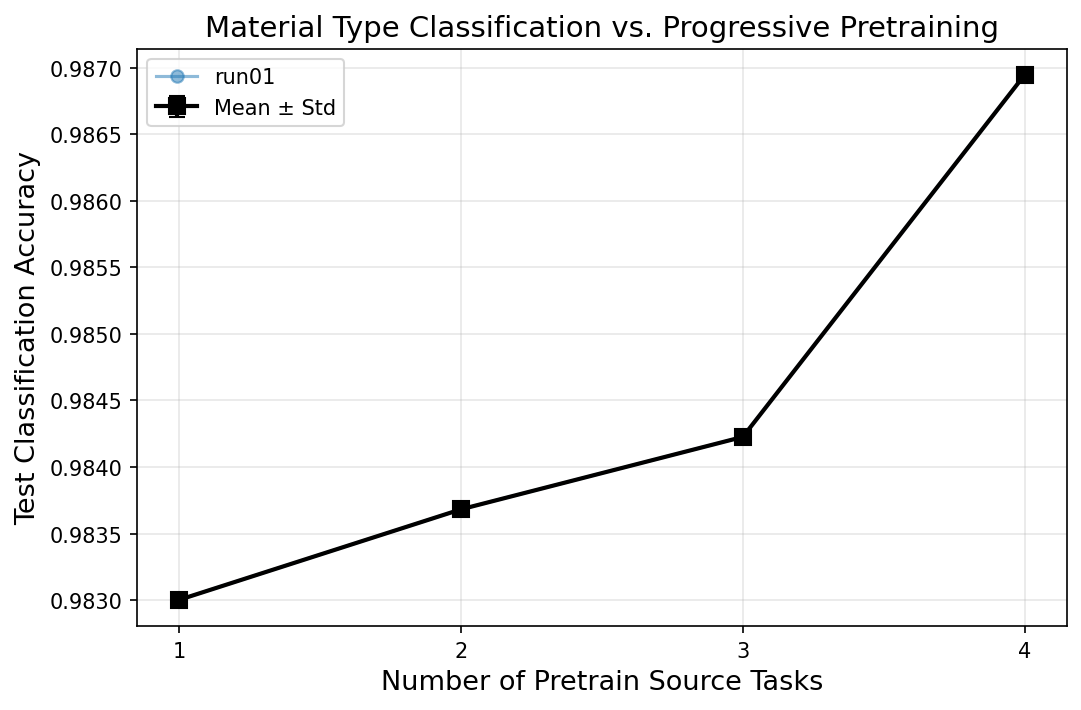


=== Accuracy Summary ===
  Stage 1: mean=0.9830 ± 0.0000
  Stage 2: mean=0.9837 ± 0.0000
  Stage 3: mean=0.9842 ± 0.0000
  Stage 4: mean=0.9869 ± 0.0000


In [9]:
# --- 汇总: 分类准确率 vs pretrain stage ---
n_stages = len(SOURCE_TASK_NAMES)

fig, ax = plt.subplots(figsize=(8, 5), dpi=150)

for run_idx, (run_acc, record) in enumerate(zip(accuracy_matrix, experiment_records)):
    stages = list(range(1, len(run_acc) + 1))
    ax.plot(stages, run_acc, "o-", alpha=0.5, label=f"{record['run']}")

# 计算均值和标准差
acc_array = np.array([
    [a if a is not None else np.nan for a in row]
    for row in accuracy_matrix
])
mean_acc = np.nanmean(acc_array, axis=0)
std_acc = np.nanstd(acc_array, axis=0)

stages = np.arange(1, n_stages + 1)
ax.errorbar(stages, mean_acc, yerr=std_acc, fmt="s-", color="black",
            linewidth=2, markersize=8, capsize=4, label="Mean ± Std")

ax.set_xlabel("Number of Pretrain Source Tasks", fontsize=13)
ax.set_ylabel("Test Classification Accuracy", fontsize=13)
ax.set_title("Material Type Classification vs. Progressive Pretraining", fontsize=14)
ax.set_xticks(stages)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

fig.savefig(output_dir / "accuracy_vs_stages.png", bbox_inches="tight")
plt.show()

# 打印数值总结
print("\n=== Accuracy Summary ===")
for s in range(n_stages):
    print(f"  Stage {s+1}: mean={mean_acc[s]:.4f} ± {std_acc[s]:.4f}")

In [10]:
# --- 每个 run 的 task 顺序和最终准确率 ---
print("=== Per-Run Summary ===")
for record, accs in zip(experiment_records, accuracy_matrix):
    run = record["run"]
    seq = record["task_sequence"]
    final_acc = accs[-1] if accs else None
    print(f"  {run}: order={seq}, final_acc={final_acc:.4f}" if final_acc else f"  {run}: order={seq}, no result")

=== Per-Run Summary ===
  run01: order=['efermi', 'thermal_conductivity', 'density', 'dos_density'], final_acc=0.9869
